# Dataset 

In [ ]:
import pandas as pd

# Read the text file mapping with error handling
mapping_file = "./Dataset/Animal_Class_Map.txt"

data = []

# Open and read the file line by line
with open(mapping_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    line = line.strip()  # Remove trailing spaces and newline characters
    if not line:  # Skip empty lines
        continue

    # Detect file extensions
    if '.jpg' in line:
        ext = '.jpg'
    elif '.jpeg' in line:
        ext = '.jpeg'
    elif '.png' in line:
        ext = '.png'
    else:
        print(f"Skipping invalid line: {line}")
        continue  # Skip lines without a valid image extension

    # Find index of file extension and extract image path
    img_index = line.index(ext) + len(ext)
    image_path = line[:img_index]

    # Extract class labels (everything after the image path)
    class_labels = line[img_index:].strip().split()  # Remove extra spaces

    data.append([image_path, class_labels])

# Convert to Pandas DataFrame
df = pd.DataFrame(data, columns=["image_path", "class_label"])

# Verify results
print(f"Total samples: {len(df)}")
print("First 5 entries:")
print(df.head())
print("\nLast 5 entries:")
print(df.tail())


Total samples: 39121
First 5 entries:
                                          image_path  class_label
0  /kaggle/input/augmented-day-night-voc-dataset/...        [Cow]
1  /kaggle/input/augmented-day-night-voc-dataset/...   [MuskDeer]
2  /kaggle/input/augmented-day-night-voc-dataset/...     [RedFox]
3  /kaggle/input/augmented-day-night-voc-dataset/...  [BlackBear]
4  /kaggle/input/augmented-day-night-voc-dataset/...     [Weasel]

Last 5 entries:
                                              image_path class_label
39116  /kaggle/input/augmented-day-night-voc-dataset/...    [Badger]
39117  /kaggle/input/augmented-day-night-voc-dataset/...   [Leopard]
39118  /kaggle/input/augmented-day-night-voc-dataset/...       [Dog]
39119  /kaggle/input/augmented-day-night-voc-dataset/...    [Badger]
39120  /kaggle/input/augmented-day-night-voc-dataset/...   [Leopard]


In [3]:
# ============================
# Settings
# ============================
batch_size = 4
num_epochs = 20
num_classes = 14
lr = 0.001
weight_decay = 5e-4
delta = 0.6 # 0 = learnable DRS
global_counter = 0
show_interval = 1000
logdir = './logs'
save_folder = './checkpoints'

# DataLoader

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import ast

class FishDataset(Dataset):
    def __init__(self, df, num_classes=14, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        label_list = row['class_label']
    
        # Convert from something like ['23'] or ['23', '26'] to int list
        label_list = [int(x) for x in label_list]
    
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
    
        label = torch.zeros(self.num_classes)
        for l in label_list:
            if l < self.num_classes:  # safety check
                label[l] = 1.0
    
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = FishDataset(train_df, num_classes=14, transform=train_transform)
val_dataset = FishDataset(val_df, num_classes=14, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set number of classes
num_classes = 14

from tqdm import tqdm
import torch.nn.functional as F

best_val_loss = float('inf')

# Accuracy functions
def multilabel_accuracy(y_pred, y_true, threshold=0.5):
    y_pred = torch.sigmoid(y_pred) > threshold
    y_true = y_true.bool()
    correct = (y_pred == y_true).sum().item()
    total = y_true.numel()
    return correct / total

def element_wise_accuracy(y_pred, y_true, threshold=0.5):
    y_pred = torch.sigmoid(y_pred) > threshold
    y_true = y_true.bool()
    correct_per_sample = (y_pred & y_true).sum(dim=1)
    total_labels_per_sample = y_true.sum(dim=1).clamp(min=1)
    acc_per_sample = correct_per_sample.float() / total_labels_per_sample
    return acc_per_sample.mean().item()


cuda


In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

import torch.optim as optim

# ===============================
# Poly Optimizer (optional)
# ===============================
class PolyOptimizer(optim.SGD):
    def __init__(self, params, lr, weight_decay, max_step, momentum=0.9):
        super().__init__(params, lr=lr, weight_decay=weight_decay, momentum=momentum)
        self.param_groups = params
        self.global_step = 0
        self.max_step = max_step
        self.momentum = momentum
        self.__initial_lr = [group['lr'] for group in self.param_groups]

    def step(self, closure=None):
        if self.global_step < self.max_step:
            lr_mult = (1 - self.global_step / self.max_step) ** self.momentum
            for i in range(len(self.param_groups)):
                self.param_groups[i]['lr'] = self.__initial_lr[i] * lr_mult

        super().step(closure)
        self.global_step += 1


# ===============================
# Polynomial LR scheduler function
# ===============================
def lr_poly(base_lr, iter, max_iter, power=0.9):
    return base_lr * ((1 - float(iter) / max_iter) ** power)


def reduce_lr_poly(optimizer, global_iter, base_lr, max_iter, power=0.9):
    """Update LR for all param groups using polynomial decay."""
    new_lr = lr_poly(base_lr=base_lr, iter=global_iter, max_iter=max_iter, power=power)
    for group in optimizer.param_groups:
        group['lr'] = new_lr


# ===============================
# Step-wise LR drop
# ===============================
def reduce_lr(epoch, optimizer, decay_points, factor=0.1):
    """
    Reduces learning rate at specified epochs.
    decay_points: list of integers (e.g., [5, 10])
    """
    if epoch in decay_points:
        for g in optimizer.param_groups:
            g['lr'] = g['lr'] * factor
            print(f"→ LR reduced at epoch {epoch}: {g['lr']:.6f}")
        return True
    return False


# Visualization

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ========= VISUALIZATION FUNCTION ==========
def visualize_activations(epoch,
                          model,
                          image_path,
                          num_classes=14,
                          input_size=512,
                          device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    print(f"[VIS] Visualizing model activations @ epoch {epoch}")

    # ----- Hook Setup -----
    activations = {}
    hook_layers = [
        'layer1_relu1', 'layer1_relu2',
        'layer2_relu1', 'layer2_relu2',
        'layer3_relu1', 'layer3_relu2', 'layer3_relu3',
        'layer4_relu1', 'layer4_relu2', 'layer4_relu3',
        'layer5_relu1', 'layer5_relu2', 'layer5_relu3',
        'extra_relu1', 'extra_relu2', 'extra_relu3'
    ]

    def hook_fn(name):
        def hook(m, inp, out):
            activations[name] = out.detach()
        return hook

    for name in hook_layers:
        layer = getattr(model.module if hasattr(model, 'module') else model, name, None)
        if layer is not None:
            layer.register_forward_hook(hook_fn(name))
        else:
            print(f"Layer not found: {name}")

    # ----- Image Preprocessing -----
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    original_img = Image.open(image_path).convert('RGB')
    img_tensor = transform(original_img).unsqueeze(0).to(device)

    # ----- Forward Pass -----
    model.eval()
    with torch.no_grad():
        out = model(img_tensor)

    if isinstance(out, tuple):
        logits, drs_cam = out
    else:
        logits = out
        drs_cam = None

    top_class = torch.sigmoid(logits)[0].argmax().item()
    print(f"Top predicted class: {top_class}")

    # ----- Heatmap Overlay Function -----
    def overlay_heatmap(feature, base_img, size=input_size):
        fmap = feature[0].mean(dim=0).cpu().numpy()
        fmap = np.maximum(fmap, 0)
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
        fmap = np.uint8(fmap * 255)
        heatmap = cv2.applyColorMap(fmap, cv2.COLORMAP_JET)

        base = np.array(base_img.resize((size, size)))
        if base.ndim == 2:
            base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
        elif base.shape[2] == 1:
            base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)

        if base.dtype != np.uint8:
            base = np.uint8(base)

        if heatmap.shape != base.shape:
            heatmap = cv2.resize(heatmap, (base.shape[1], base.shape[0]))

        overlay = cv2.addWeighted(base, 0.5, heatmap, 0.5, 0)
        return overlay[..., ::-1]  # BGR to RGB

    # ----- Plot Original + Activations -----
    plt.figure(figsize=(24, 12))
    cols = 6
    i = 1

    plt.subplot((len(hook_layers) + 2) // cols, cols, i)
    plt.imshow(original_img.resize((input_size, input_size)))
    plt.title("Original Image")
    plt.axis('off')
    i += 1

    for name in hook_layers:
        if name in activations:
            overlay = overlay_heatmap(activations[name], original_img)
            plt.subplot((len(hook_layers) + 2) // cols, cols, i)
            plt.imshow(overlay)
            plt.title(name)
            plt.axis('off')
            i += 1

    if drs_cam is not None:
        final_cam = drs_cam[0][top_class].cpu().numpy()
        final_cam_norm = (final_cam - final_cam.min()) / (final_cam.max() - final_cam.min() + 1e-5)
        final_cam_uint8 = np.uint8(final_cam_norm * 255)
        drs_heatmap = cv2.applyColorMap(final_cam_uint8, cv2.COLORMAP_JET)
        drs_overlay = cv2.addWeighted(np.array(original_img.resize((input_size, input_size))), 0.5, drs_heatmap, 0.5, 0)

        plt.subplot((len(hook_layers) + 2) // cols, cols, i)
        plt.imshow(drs_overlay[..., ::-1])
        plt.title("Final DRS CAM")
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch} Activations", fontsize=16)
    plt.tight_layout()
    plt.show()


# Training

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from vgg16 imoprt vgg16

os.makedirs(logdir, exist_ok=True)
os.makedirs(save_folder, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ============================
# Model & Optimizer
# ============================
model = vgg16(pretrained=False, delta=delta)
model = torch.nn.DataParallel(model).to(device)
param_groups = model.module.get_parameter_groups()

optimizer = optim.SGD([
    {'params': param_groups[0], 'lr': lr},
    {'params': param_groups[1], 'lr': 2 * lr},
    {'params': param_groups[2], 'lr': 10 * lr},
    {'params': param_groups[3], 'lr': 20 * lr}],
    momentum=0.9,
    weight_decay=weight_decay,
    nesterov=True
)

# ============================
# Data Loaders
# ============================

print("Train samples:", len(train_loader))
print("Val samples:", len(val_loader))

# ============================
# Train Function
# ============================
def train(epoch):
    global global_counter
    model.train()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()

    reduce_lr(epoch, optimizer, decay_points=[5, 10])

    for idx, (img, label) in enumerate(tqdm(train_loader)):
        img = img.to(device)
        label = label.to(device)

        logits = model(img)
        loss = F.multilabel_soft_margin_loss(logits, label)
        acc = element_wise_accuracy(logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), img.size(0))
        acc_meter.update(acc, img.size(0))

        global_counter += 1
        if global_counter % show_interval == 0:
            

            print(f"[TRAIN] Epoch {epoch} | Step {idx+1}/{len(train_loader)} | "
                  f"Loss: {loss_meter.avg:.4f} | EleAcc: {acc_meter.avg:.4f}")

# ============================
# Validate Function
# ============================
def validate(epoch):
    model.eval()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):
            img = img.to(device)
            label = label.to(device)

            logits, _ = model(img, label)
            loss = F.multilabel_soft_margin_loss(logits, label)
            acc = element_wise_accuracy(logits, label)

            loss_meter.update(loss.item(), img.size(0))
            acc_meter.update(acc, img.size(0))

    print(f"[VAL] Epoch {epoch} | Loss: {loss_meter.avg:.4f} | EleAcc: {acc_meter.avg:.4f}")
    return acc_meter.avg

# ============================
# Training Loop with Checkpoint
# ============================
best_acc = 0.0

for epoch in range(1, num_epochs + 1):
    train(epoch)
    #val_acc = validate(epoch)
    visualize_activations(epoch, model)

    checkpoint = {
        'epoch': epoch,
        'model_state': model.module.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'global_counter': global_counter
    }
    path=f"drs_non_model_{epoch}.pth"
    torch.save(checkpoint, os.path.join(save_folder, path))


[VIS] Visualizing model activations @ epoch 20
Top predicted class: 5
[SAVE] Saved activation for extra_relu3 to activations_epoch_20/extra_relu3.npy


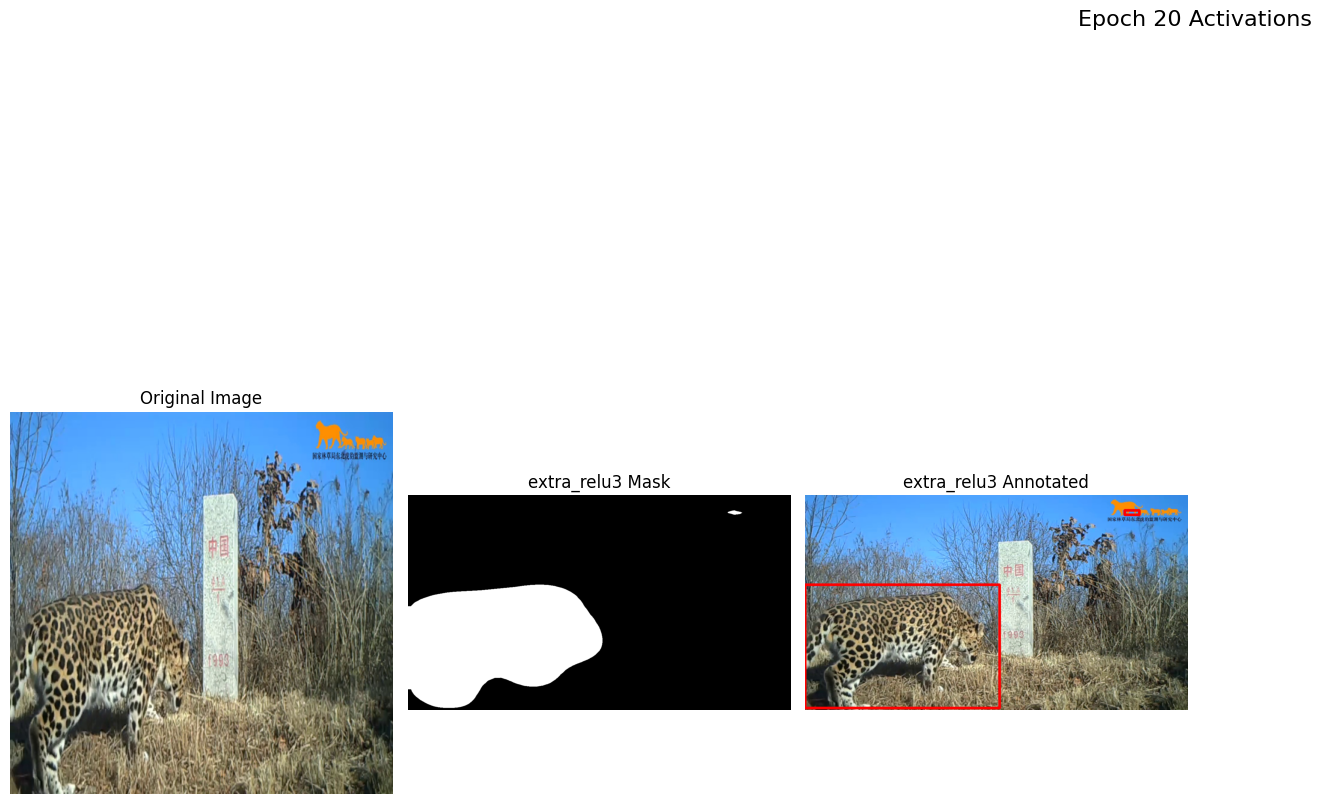

In [18]:
visualize_activations(20,model,image_path='/kaggle/input/augmented-day-night-voc-dataset/new_day/new_day/voc_day/JPEGImages/AmurLeopard_1002.jpg')

# Loading the saved model 

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set number of classes
num_classes = 14
import torch
import os

# Make sure the same delta value is used
delta = 0.6
checkpoint_path = './models/DRS_VGG16.pth'

# Step 1: Rebuild the model architecture
model = vgg16(pretrained=False, delta=delta)
model = torch.nn.DataParallel(model).to(device)

# Step 2: Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Step 3: Load state dict
model.module.load_state_dict(checkpoint['model_state'])

# Get parameter groups
param_groups = model.module.get_parameter_groups()

# Rebuild the optimizer like during training
optimizer = optim.SGD([
    {'params': param_groups[0], 'lr': 0.001},
    {'params': param_groups[1], 'lr': 0.002},
    {'params': param_groups[2], 'lr': 0.01},
    {'params': param_groups[3], 'lr': 0.02},
], momentum=0.9, weight_decay=5e-4, nesterov=True)

# Load state dict
optimizer.load_state_dict(checkpoint['optimizer_state'])

print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']} with best accuracy")


cuda
✅ Loaded checkpoint from epoch 20 with best accuracy


# Annotation Genreator

[VIS] Visualizing model activations @ epoch 1
Top predicted class: 5
[SAVE] Saved activation for extra_relu3 to activations_epoch_1/extra_relu3.npy


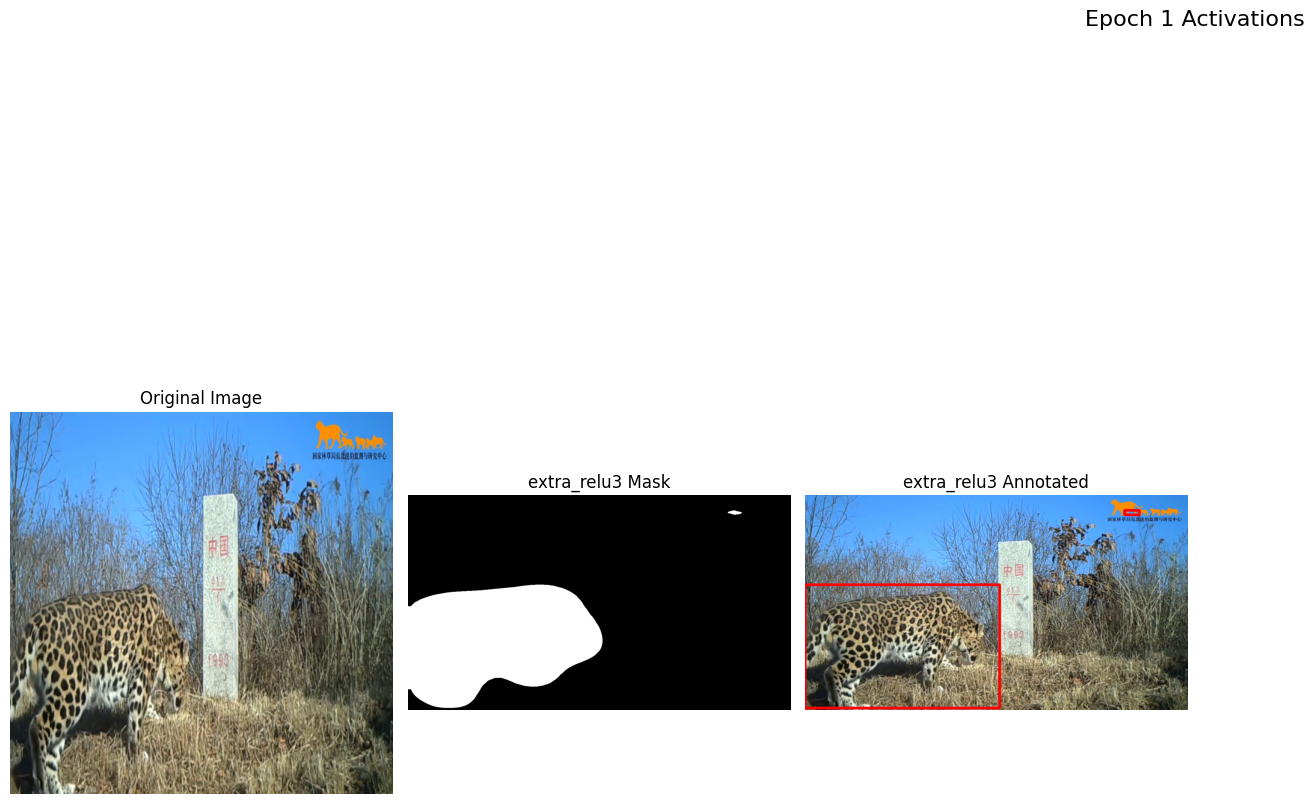

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import math

# ========= VISUALIZATION FUNCTION ==========
def visualize_activations(epoch,
                          model,
                          image_path,
                          num_classes=14,
                          input_size=512,
                          device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    print(f"[VIS] Visualizing model activations @ epoch {epoch}")

    # ----- Hook Setup -----
    activations = {}
    hook_layers = ['extra_relu3']  # Only this layer

    def hook_fn(name):
        def hook(m, inp, out):
            activations[name] = out.detach()
        return hook

    for name in hook_layers:
        layer = getattr(model.module if hasattr(model, 'module') else model, name, None)
        if layer is not None:
            layer.register_forward_hook(hook_fn(name))
        else:
            print(f"Layer not found: {name}")

    # ----- Image Preprocessing -----
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    original_img = Image.open(image_path).convert('RGB')
    img_tensor = transform(original_img).unsqueeze(0).to(device)

    # ----- Forward Pass -----
    model.eval()
    with torch.no_grad():
        out = model(img_tensor)

    if isinstance(out, tuple):
        logits, drs_cam = out
    else:
        logits = out
        drs_cam = None

    top_class = torch.sigmoid(logits)[0].argmax().item()
    print(f"Top predicted class: {top_class}")

    # ----- Save Activations as .npy -----
    save_dir = f'activations_epoch_{epoch}'
    os.makedirs(save_dir, exist_ok=True)

    for name, act in activations.items():
        act_np = act.cpu().numpy()
        save_path = os.path.join(save_dir, f'{name}.npy')
        np.save(save_path, act_np)
        print(f"[SAVE] Saved activation for {name} to {save_path}")

    # ----- Heatmap Overlay Function -----
    def get_binary_mask_and_annotated_image(feature, base_img, size=input_size, threshold=0.5):
        fmap = feature[0].mean(dim=0).cpu().numpy()
        fmap = np.maximum(fmap, 0)
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)  # Normalize to [0,1]
        orig_w, orig_h = base_img.size
        fmap_resized = cv2.resize(fmap, (orig_w, orig_h))

    
        # Threshold to binary
        binary_mask = (fmap_resized > threshold).astype(np.uint8) * 255
    
        # Find contours on binary mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Prepare base image
        base = np.array(base_img)  # Keep original size
        if base.ndim == 2 or base.shape[2] == 1:
            base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
        elif base.shape[2] == 3:
            base = cv2.cvtColor(base, cv2.COLOR_RGB2BGR)
    
        # Draw rectangles around each contour
        annotated = base.copy()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(annotated, (x, y), (x + w, y + h), (0, 0, 255), 7)
    
        return binary_mask, annotated[..., ::-1]  # Convert BGR to RGB



    # ----- Plot Original + Activation -----
    cols = 6
    rows = math.ceil((len(hook_layers) + 1) / cols)
    plt.figure(figsize=(24, 12))
    i = 1

    plt.subplot(rows, cols, i)
    plt.imshow(original_img.resize((input_size, input_size)))
    plt.title("Original Image")
    plt.axis('off')
    i += 1

    for name in hook_layers:
        if name in activations:
            binary_mask, annotated = get_binary_mask_and_annotated_image(activations[name], original_img)
    
            plt.subplot(rows, cols, i)
            plt.imshow(binary_mask, cmap='gray')
            plt.title(f"{name} Mask")
            plt.axis('off')
            i += 1
    
            plt.subplot(rows, cols, i)
            plt.imshow(annotated)
            plt.title(f"{name} Annotated")
            plt.axis('off')
            i += 1


    if drs_cam is not None:
        final_cam = drs_cam[0][top_class].cpu().numpy()
        final_cam_norm = (final_cam - final_cam.min()) / (final_cam.max() - final_cam.min() + 1e-5)
        final_cam_uint8 = np.uint8(final_cam_norm * 255)
        drs_heatmap = cv2.applyColorMap(final_cam_uint8, cv2.COLORMAP_JET)
        drs_overlay = cv2.addWeighted(np.array(original_img.resize((input_size, input_size))), 0.5, drs_heatmap, 0.5, 0)

        plt.subplot(rows, cols, i)
        plt.imshow(drs_overlay[..., ::-1])
        plt.title("Final DRS CAM")
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch} Activations", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_activations(1,model,'/kaggle/input/augmented-day-night-voc-dataset/new_day/new_day/voc_day/JPEGImages/AmurLeopard_1002.jpg')

# Annotation after Filter using Resnet50

[INFO] Processing /kaggle/input/augmented-day-night-voc-dataset/new_day/new_day/voc_day/JPEGImages/AmurLeopard_1001.jpg
3
[SKIP] Low confidence (0.8403) — Skipping this prediction.
5
VGG Prediction:  5 Confidence:  1.0
Resnet Prediction:  5 Confidence:  1.0
3
[SKIP] Low confidence (0.9972) — Skipping this prediction.
9
[SKIP] Low confidence (1.0000) — Skipping this prediction.
[SAVE] Saved YOLO labels to yolo_outputs/AmurLeopard_1001.txt


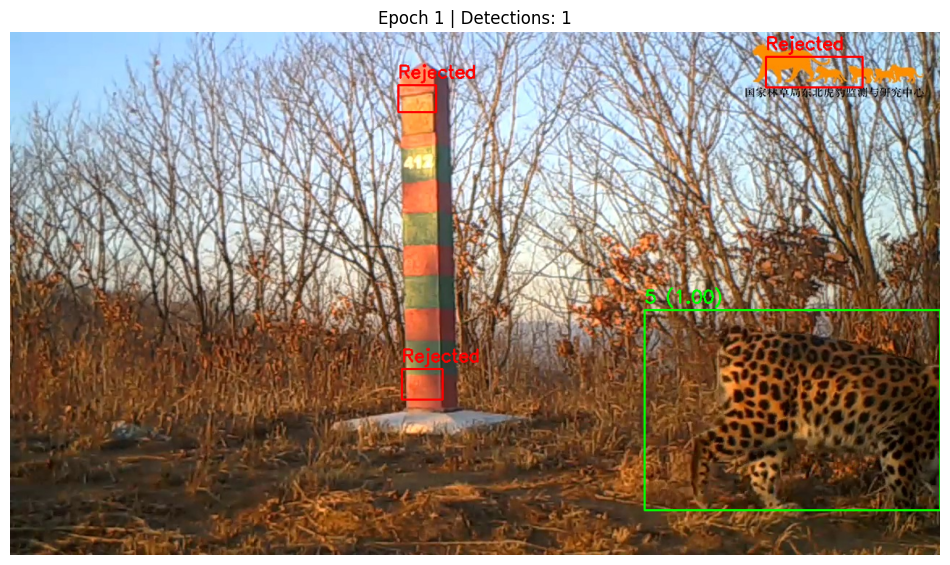

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

# ========= CLASSIFIER SETUP ===========
class ResNet50MultiLabel(nn.Module):
    def __init__(self, num_classes=14):
        super(ResNet50MultiLabel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load classifier model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = ResNet50MultiLabel(num_classes=14).to(device)
classifier.load_state_dict(torch.load('./models/Resnet_filter.pth', map_location=device))
classifier.eval()

# Preprocessing for classifier
classify_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ========= VISUALIZATION & YOLO SAVE FUNCTION ===========
def get_activation_bbox_and_classify(epoch, model, image_path, input_size=512, threshold=0.6, save_dir="output_labels"):

    os.makedirs(save_dir, exist_ok=True)

    print(f"[INFO] Processing {image_path}")
    base_img = Image.open(image_path).convert('RGB')
    orig_w, orig_h = base_img.size

    # Setup hook for extracting activation
    activations = {}
    layer_name = 'extra_relu3'
    
    def hook_fn(m, inp, out):
        activations[layer_name] = out.detach()
    
    layer = getattr(model.module if hasattr(model, 'module') else model, layer_name, None)
    if layer is not None:
        layer.register_forward_hook(hook_fn)
    else:
        print(f"Layer {layer_name} not found.")
        return

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(base_img).unsqueeze(0).to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(img_tensor)
    # Top CAM-predicted class from VGG
    with torch.no_grad():
        cam_output = model(img_tensor)
        top_pred_class = torch.sigmoid(cam_output)[0].argmax().item()

    # Activation → Binary Mask
    fmap = activations[layer_name][0].mean(dim=0).cpu().numpy()
    fmap = np.maximum(fmap, 0)
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
    fmap_resized = cv2.resize(fmap, (orig_w, orig_h))

    binary_mask = (fmap_resized >0.4).astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    annotated_img = np.array(base_img)
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR)

    yolo_lines = []

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        x_center = (x + w / 2) / orig_w
        y_center = (y + h / 2) / orig_h
        norm_w = w / orig_w
        norm_h = h / orig_h
    
        # Crop from original image
        cropped = base_img.crop((x, y, x + w, y + h))
        crop_tensor = classify_transform(cropped).unsqueeze(0).to(device)
    
        with torch.no_grad():
            output = classifier(crop_tensor)
            prob = torch.sigmoid(output)[0]
            resnet_pred_class = prob.argmax().item()
            confidence = prob[resnet_pred_class].item()
    
        # ======= Get VGG's top class (CAM) =======
        # NOTE: You need to define this value
        # Example:
        top_pred_class = model(img_tensor).sigmoid()[0].argmax().item()
    
        # Check agreement
        
        class_name = resnet_pred_class
        print(class_name)
        if confidence >= 0.75 and top_pred_class==resnet_pred_class:
            print("VGG Prediction: ",top_pred_class, "Confidence: ",prob[top_pred_class].item())
            print("Resnet Prediction: ",resnet_pred_class, "Confidence: ",prob[resnet_pred_class].item())
            yolo_line = f"{resnet_pred_class} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}"
            yolo_lines.append(yolo_line)

            # Green box and label
            cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(annotated_img, f"{resnet_pred_class} ({confidence:.2f})", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        else:
            # Green box and label
            cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(annotated_img, f"Rejected", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            print(f"[SKIP] Low confidence ({confidence:.4f}) — Skipping this prediction.")

        

    # Save YOLO annotation
    image_filename = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(save_dir, f"{image_filename}.txt")

    with open(label_path, "w") as f:
        for line in yolo_lines:
            f.write(line + "\n")

    print(f"[SAVE] Saved YOLO labels to {label_path}")


    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Epoch {epoch} | Detections: {len(yolo_lines)}")
    plt.axis('off')
    plt.show()

# ====== CALL THE FUNCTION ========
# Assume model1 is your CAM model
get_activation_bbox_and_classify(
    epoch=1,
    model=model,
    image_path='/kaggle/input/augmented-day-night-voc-dataset/new_day/new_day/voc_day/JPEGImages/AmurLeopard_1001.jpg',
    input_size=512,
    threshold=0.6,
    save_dir='yolo_outputs'
)


[INFO] Processing /kaggle/input/augmented-day-night-voc-dataset/new_day/new_day/voc_day/JPEGImages/AmurLeopard_1001.jpg
5
VGG Prediction:  5 Confidence:  1.0
Resnet Prediction:  5 Confidence:  1.0
[SAVE] Saved YOLO labels to yolo_outputs/AmurLeopard_1001.txt


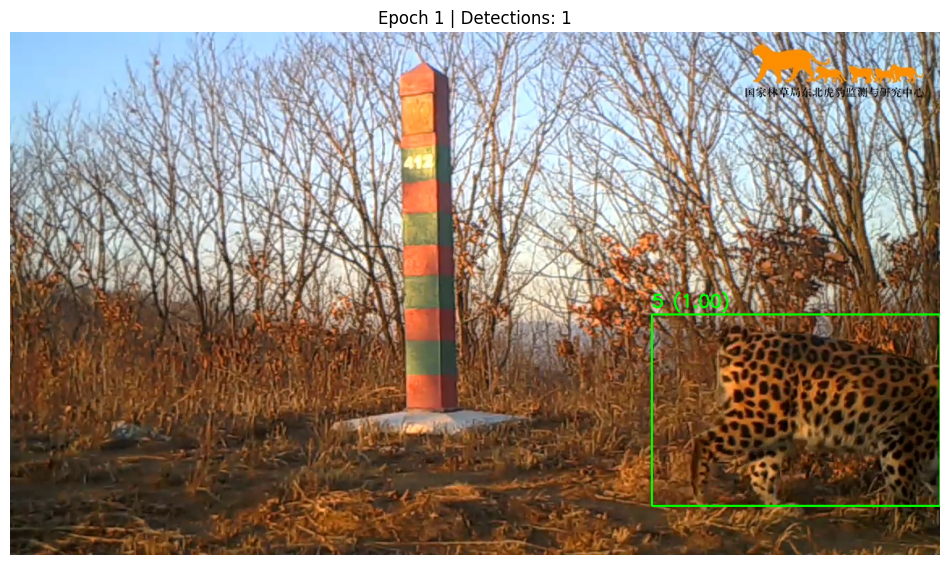

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

# ========= CLASSIFIER SETUP ===========
class ResNet50MultiLabel(nn.Module):
    def __init__(self, num_classes=14):
        super(ResNet50MultiLabel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load classifier model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = ResNet50MultiLabel(num_classes=14).to(device)
classifier.load_state_dict(torch.load('./models/Resnet_filter.pth', map_location=device))
classifier.eval()

# Preprocessing for classifier
classify_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ========= VISUALIZATION & YOLO SAVE FUNCTION ===========
def get_activation_bbox_and_classify(epoch, model, image_path, input_size=512, threshold=0.6, save_dir="output_labels"):

    os.makedirs(save_dir, exist_ok=True)

    print(f"[INFO] Processing {image_path}")
    base_img = Image.open(image_path).convert('RGB')
    orig_w, orig_h = base_img.size

    # Setup hook for extracting activation
    activations = {}
    layer_name = 'extra_relu3'
    
    def hook_fn(m, inp, out):
        activations[layer_name] = out.detach()
    
    layer = getattr(model.module if hasattr(model, 'module') else model, layer_name, None)
    if layer is not None:
        layer.register_forward_hook(hook_fn)
    else:
        print(f"Layer {layer_name} not found.")
        return

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(base_img).unsqueeze(0).to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(img_tensor)
    # Top CAM-predicted class from VGG
    with torch.no_grad():
        cam_output = model(img_tensor)
        top_pred_class = torch.sigmoid(cam_output)[0].argmax().item()

    # Activation → Binary Mask
    fmap = activations[layer_name][0].mean(dim=0).cpu().numpy()
    fmap = np.maximum(fmap, 0)
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
    fmap_resized = cv2.resize(fmap, (orig_w, orig_h))

    binary_mask = (fmap_resized >0.6).astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    annotated_img = np.array(base_img)
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR)

    yolo_lines = []

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        x_center = (x + w / 2) / orig_w
        y_center = (y + h / 2) / orig_h
        norm_w = w / orig_w
        norm_h = h / orig_h
    
        # Crop from original image
        cropped = base_img.crop((x, y, x + w, y + h))
        crop_tensor = classify_transform(cropped).unsqueeze(0).to(device)
    
        with torch.no_grad():
            output = classifier(crop_tensor)
            prob = torch.sigmoid(output)[0]
            resnet_pred_class = prob.argmax().item()
            confidence = prob[resnet_pred_class].item()
    
        # ======= Get VGG's top class (CAM) =======
        # NOTE: You need to define this value
        # Example:
        top_pred_class = model(img_tensor).sigmoid()[0].argmax().item()
    
        # Check agreement
        
        class_name = resnet_pred_class
        print(class_name)
        if confidence >= 0.75:
            print("VGG Prediction: ",top_pred_class, "Confidence: ",prob[top_pred_class].item())
            print("Resnet Prediction: ",resnet_pred_class, "Confidence: ",prob[resnet_pred_class].item())
            yolo_line = f"{resnet_pred_class} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}"
            yolo_lines.append(yolo_line)

            # Green box and label
            cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(annotated_img, f"{resnet_pred_class} ({confidence:.2f})", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        else:
            pass

        

    # Save YOLO annotation
    image_filename = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(save_dir, f"{image_filename}.txt")

    with open(label_path, "w") as f:
        for line in yolo_lines:
            f.write(line + "\n")

    print(f"[SAVE] Saved YOLO labels to {label_path}")


    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Epoch {epoch} | Detections: {len(yolo_lines)}")
    plt.axis('off')
    plt.show()

# ====== CALL THE FUNCTION ========
# Assume model1 is your CAM model
get_activation_bbox_and_classify(
    epoch=1,
    model=model,
    image_path='/kaggle/input/augmented-day-night-voc-dataset/new_day/new_day/voc_day/JPEGImages/AmurLeopard_1001.jpg',
    input_size=512,
    threshold=0.6,
    save_dir='yolo_outputs'
)


# Annotation Generation for entire Dataset

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========= CLASSIFIER SETUP ===========
class ResNet50MultiLabel(nn.Module):
    def __init__(self, num_classes=14):
        super(ResNet50MultiLabel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load classifier
classifier = ResNet50MultiLabel(num_classes=14).to(device)
classifier.load_state_dict(torch.load('./models/Resnet_filter.pth', map_location=device))
classifier.eval()

# Classification preprocessing
classify_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ========= MAIN FUNCTION ===========
def process_image(image_path, model, classifier, input_size=512, threshold=0.4, confidence_threshold=0.8, save_root="output_labels", visualize_path=None):
    base_img = Image.open(image_path).convert('RGB')
    orig_w, orig_h = base_img.size

    # Hook for CAM
    activations = {}
    layer_name = 'layer4'  # last conv block

    def hook_fn(m, inp, out):
        activations[layer_name] = out.detach()

    layer = dict([*model.model.named_modules()])[layer_name]
    layer.register_forward_hook(hook_fn)

    # Transform input
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(base_img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        top_pred_class = torch.sigmoid(output)[0].argmax().item()

    # Get activation map
    fmap = activations[layer_name][0].mean(dim=0).cpu().numpy()
    fmap = np.maximum(fmap, 0)
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
    fmap_resized = cv2.resize(fmap, (orig_w, orig_h))
    binary_mask = (fmap_resized > threshold).astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    annotated_img = np.array(base_img)
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR)

    yolo_lines = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        x_center = (x + w / 2) / orig_w
        y_center = (y + h / 2) / orig_h
        norm_w = w / orig_w
        norm_h = h / orig_h

        cropped = base_img.crop((x, y, x + w, y + h))
        crop_tensor = classify_transform(cropped).unsqueeze(0).to(device)

        with torch.no_grad():
            output = classifier(crop_tensor)
            prob = torch.sigmoid(output)[0]
            resnet_pred_class = prob.argmax().item()
            confidence = prob[resnet_pred_class].item()

        if confidence >= confidence_threshold:
            yolo_line = f"{resnet_pred_class} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}"
            yolo_lines.append(yolo_line)

            cv2.rectangle(annotated_img, (x, y), (x + w, y + h), (0, 255, 0), 5)
            cv2.putText(annotated_img, f"{resnet_pred_class} ({confidence:.2f})", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Save YOLO label
    if len(yolo_lines) > 0:
        subfolder = os.path.dirname(image_path.replace("/kaggle/input/augmented-day-night-voc-dataset/", ""))
        label_folder = os.path.join(save_root, subfolder)
        os.makedirs(label_folder, exist_ok=True)

        image_filename = os.path.splitext(os.path.basename(image_path))[0]
        label_path = os.path.join(label_folder, f"{image_filename}.txt")

        with open(label_path, "w") as f:
            for line in yolo_lines:
                f.write(line + "\n")

    # Visualize only the selected image
    if image_path == visualize_path:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detections: {len(yolo_lines)}")
        plt.axis('off')
        plt.show()

# ============ DRIVER =============
train_txt_path = "/kaggle/input/train-loader/train.txt"
visualize_image_path = "/kaggle/input/augmented-day-night-voc-dataset/new_day/new_day/voc_day/JPEGImages/aug_4_MuskDeer_559.jpg"
print("Fetching...")
with open(train_txt_path, "r") as f:
    image_paths = [line.strip() for line in f.readlines() if line.strip()]

print("Starting....")
for img_path in tqdm(image_paths, desc="Processing images"):
    try:
        process_image(img_path, classifier, classifier, visualize_path=visualize_image_path)
    except Exception as e:
        print(f"[ERROR] {img_path} → {e}")
print("Done....")

In [ ]:
import os
import zipfile

# Define the folder to zip
folder_to_zip = "/kaggle/working/output_labels"
zip_filename = "/kaggle/working/output_labels.zip"

# Create a zip archive
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=folder_to_zip)
            zipf.write(file_path, arcname)

print(f"✅ Zipped folder into: {zip_filename}")
